# Using Physics-Based Loss to Better Generalize Model Training 
From modified Beer-Lambert Law, we know that 
$$
\Delta OD = <L_i(r)> \Delta \mu_(a,i)
$$
Where, $\Delta OD$ is the pulsation ratio(for a given wavelength) defined as $log(I_2)/log(I_1)$, i is the index of the tissue layer where pulsation occurs, $<L>$ corresponds to the source-detector distance (SDD) dependent **mean** photon pathlength within that layer. This can be further modified as 
$$
\Delta OD = <L_i(r)> \Delta c_(Hb) \times \epsilon(S)
$$
The corresponding loss term should thus be
$$
(\Delta OD - <L_i(r)> \Delta c_(Hb) \times \epsilon(S)) ^ 2
$$


In [16]:
from pathlib import Path
import json
from torch.optim import Adam, SGD
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from sklearn import preprocessing
from inverse_modelling_tfo.data.data_loader_gen import generate_data_loaders
from inverse_modelling_tfo.models import RandomSplit, ValidationMethod, HoldOneOut, CVSplit, CombineMethods
from inverse_modelling_tfo.models.custom_models import (
    PerceptronBD,
    CNN2FC,
    FeatureResidualNetwork,
    CNN2FC2dInput,
    SplitChannelCNN
)
from inverse_modelling_tfo.visualization import generate_model_error_and_prediction
from inverse_modelling_tfo.models import SumLoss, TorchLossWrapper, BLPathlengthLoss, ModelTrainerFactory
import torchinfo
from inverse_modelling_tfo.misc.misc_training import set_seed

# Set my GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Pre-save data

In [18]:
# file_name = 'logI2_by_I1'
file_name = 'pulsation_ratio'

# Load data
DATA_PATH = Path().resolve().parent.parent / "data" / "processed_data" / f"{file_name}.pkl"
data = pd.read_pickle(DATA_PATH)

# Load Configs
CONFIG_PATH = Path().resolve().parent.parent / "data" / "processed_data" / f"{file_name}.json"
with open(CONFIG_PATH, "r") as f:
    config = json.load(f)
labels = config["labels"]
features = config["features"]


# Cleanup
data.dropna(inplace=True)

In [19]:
# Filter data so I don't have to wait for too long during training
# data = data[
#     (data["Maternal Wall Thickness"] >= 2.0)
#     & (data["Maternal Wall Thickness"] <= 12.0)
#     # & (np.round(data["Fetal Hb Concentration"], fconc_rounding).isin(groups_to_keep))
#     & (data["Fetal Saturation"] > 0.3)
#     & (data["Maternal Saturation"] > 0.95)
# ]
# print("training with", len(data), "samples")

# Combining Physics Based Terms

In [20]:
pathlength_stats = Path(r'/home/rraiyan/simulations/tfo_sim/data/pathlength_stats/dan_iccps_pencil2.pkl')
pathlength_stats = pd.read_pickle(pathlength_stats)

# Working with a single Wave Int for now - defaulting to 2 / dropping all wave int 1 features
pathlength_stats = pathlength_stats[pathlength_stats['Wave Int'] == 2]
pathlength_stats.drop(columns=['Wave Int'], inplace=True)   # Don't need this column anymore
unwanted_feature_columns = list(filter(lambda x: 'WV1' in x, features))
features = [x for x in features if x not in unwanted_feature_columns]
data.drop(columns=unwanted_feature_columns, inplace=True)

# Get the appropriate pathlength stat columns
l4_mean_column_names = list(filter(lambda x: 'L4 ppath_mean' in x, pathlength_stats.columns))
# Append the maternal wall thickness column to the pathlength stats - will be used for indexing
l4_mean = pathlength_stats[['Maternal Wall Thickness'] + l4_mean_column_names]
l4_mean.set_index(['Maternal Wall Thickness'], inplace=True)

# Append the pathlength stats to the data
for column in l4_mean.columns:
    data[column] = data['Maternal Wall Thickness'].map(l4_mean[column])


# Calculate The BL-Based Term 

In [21]:
from inverse_modelling_tfo.tools.optical_properties import get_tissue_mu_a

def calculate_mua1(row):
    mu_a = get_tissue_mu_a(0.1, row["Fetal Hb Concentration 0"], row["Fetal Saturation"], wave_int=2)
    return mu_a

def calculate_mua2(row):
    mu_a = get_tissue_mu_a(0.1, row["Fetal Hb Concentration 1"], row["Fetal Saturation"], wave_int=2)
    return mu_a

data["Fetal Mua 1"] = data.apply(calculate_mua1, axis=1)
data["Fetal Mua 2"] = data.apply(calculate_mua2, axis=1)

# Generate the BL columns
for column in l4_mean_column_names:
    data[f'{column}_BL'] = data[column] * (data['Fetal Mua 2'] - data['Fetal Mua 1'])

bl_column_names = [f'{column}_BL' for column in l4_mean_column_names]
bl_column_indices = [data.columns.get_loc(column) for column in bl_column_names]

# Vis

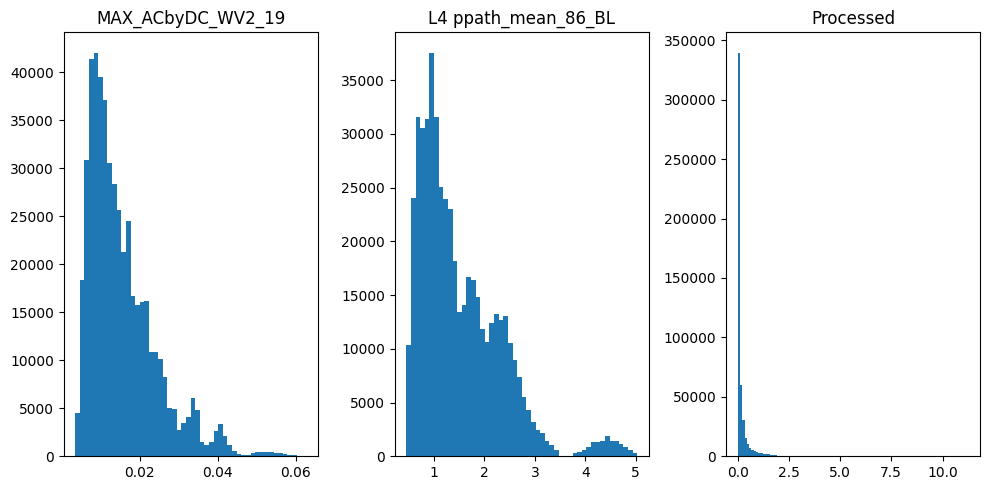

In [22]:
col1 = 'MAX_ACbyDC_WV2_19'
col2 = 'L4 ppath_mean_86_BL'
test1 = (data[col1] * 100 - data[col2]) ** 2
# plot histograms for these three series
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].hist(data[col1], bins=50)
ax[0].set_title(col1)
ax[1].hist(data[col2], bins=50)
ax[1].set_title(col2)
ax[2].hist(test1, bins=100)
ax[2].set_title('Processed')

plt.tight_layout()
plt.show()

# Setup Training Objective

In [23]:
# Predict the mu_a as well as the pathlengths for each detector
y_columns = ['Fetal Mua 1', 'Fetal Mua 2'] + l4_mean_column_names    # Fetal MuA comes first!

x_columns = features  # What to use as input

print("X Columns", x_columns)
print("Y Columns", y_columns)

X Columns ['MAX_ACbyDC_WV2_0', 'MAX_ACbyDC_WV2_1', 'MAX_ACbyDC_WV2_2', 'MAX_ACbyDC_WV2_3', 'MAX_ACbyDC_WV2_4', 'MAX_ACbyDC_WV2_5', 'MAX_ACbyDC_WV2_6', 'MAX_ACbyDC_WV2_7', 'MAX_ACbyDC_WV2_8', 'MAX_ACbyDC_WV2_9', 'MAX_ACbyDC_WV2_10', 'MAX_ACbyDC_WV2_11', 'MAX_ACbyDC_WV2_12', 'MAX_ACbyDC_WV2_13', 'MAX_ACbyDC_WV2_14', 'MAX_ACbyDC_WV2_15', 'MAX_ACbyDC_WV2_16', 'MAX_ACbyDC_WV2_17', 'MAX_ACbyDC_WV2_18', 'MAX_ACbyDC_WV2_19']
Y Columns ['Fetal Mua 1', 'Fetal Mua 2', 'L4 ppath_mean_10', 'L4 ppath_mean_15', 'L4 ppath_mean_19', 'L4 ppath_mean_24', 'L4 ppath_mean_28', 'L4 ppath_mean_33', 'L4 ppath_mean_37', 'L4 ppath_mean_41', 'L4 ppath_mean_46', 'L4 ppath_mean_50', 'L4 ppath_mean_55', 'L4 ppath_mean_59', 'L4 ppath_mean_64', 'L4 ppath_mean_68', 'L4 ppath_mean_72', 'L4 ppath_mean_77', 'L4 ppath_mean_81', 'L4 ppath_mean_86', 'L4 ppath_mean_90', 'L4 ppath_mean_94']


## Normalizing Features
x_columns will be the input features and y_columns are the target

In [24]:
## Pass in maternal info
# x_columns += ["Maternal Hb Concentration", "Maternal Saturation"]
# x_columns = list(filter(lambda X: 'alpha' in X, data.columns))
## Scale y
y_scaler = preprocessing.StandardScaler()
data[y_columns] = y_scaler.fit_transform(data[y_columns])

## Scale x
## Scheme 1 - Per detector normalization
x_scaler = preprocessing.StandardScaler()
data[x_columns] = x_scaler.fit_transform(data[x_columns])

# Custom Loss Definition

In [25]:
# from sklearn.preprocessing import StandardScaler


# class PhysicsLoss(nn.Module):
#     """
#     Beer-Lamberts Law based loss for the pulsating layer

#     This loss takes the labels and breaks them up into three parts
#         1. The actual output labels to predict
#         2. The pulsation ratio terms

#     The also loss assumes the model's predictions are in the following order
#         1. del mu(a)
#         2. L(r) - the average pathlengths for each detector

#     """

#     def __init__(
#         self,
#         output_labels_len: int,
#         label_loss_weight: float,
#         bl_loss_weight: float,
#         label_scaler,
#         pulsation_scaler,
#     ) -> None:
#         """
#         :param output_labels_len: The number of labels to predict
#         :param label_loss_weight: The weight for the label loss
#         :param bl_loss_weight: The weight for the Beer-Lambert loss
#         :param label_scaler: The scaler used to scale all of the labels (mu_a x 2 + pathlength x 20)
#         :param pulsation_scaler: The scaler used to scale the pulsation ratios
#         """
#         super().__init__()
#         self.label_loss = nn.MSELoss()
#         self.output_labels_len = output_labels_len
#         self.label_loss_weight = label_loss_weight
#         self.bl_loss_weight = bl_loss_weight
#         self.label_scaler_mean = torch.tensor(label_scaler.mean_).cuda()
#         self.label_scaler_scale = torch.tensor(label_scaler.scale_).cuda()
#         self.pulsation_scaler_mean = torch.tensor(pulsation_scaler.mean_).cuda()
#         self.pulsation_scaler_scale = torch.tensor(pulsation_scaler.scale_).cuda()

#     def forward(self, prediction, targets):
#         # Physics Term
#         scaled_mua0 = targets[:, 0].reshape(-1, 1) * self.label_scaler_scale[0] + self.label_scaler_mean[0]  
#         scaled_mua1 = targets[:, 1].reshape(-1, 1) * self.label_scaler_scale[1] + self.label_scaler_mean[1]
#         predicted_del_mu_a = scaled_mua1 - scaled_mua0  # Mua1 - Mua0
#         predicted_avg_L = prediction[:, 2:] * self.label_scaler_scale[2:] + self.label_scaler_mean[2:]
#         predicted_bl_term = predicted_del_mu_a * predicted_avg_L / 100  # Somehow we ended up with a factor of 100 here
#         # TODO: Probably figure out how that came to be!
#         target_pulsation_ratios = targets[:, self.output_labels_len :]
#         target_pulsation_ratios = self.pulsation_scaler_scale * target_pulsation_ratios + self.pulsation_scaler_mean
#         # Assuming the pulsation ratios are the same as the BL terms
#         bl_loss = self.label_loss(target_pulsation_ratios, predicted_bl_term)

#         # Label Loss - How good is the model at predicting the given labels
#         target_labels = targets[:, : self.output_labels_len]
#         label_loss = self.label_loss(prediction, target_labels)

#         # Total Loss
#         total_loss = self.label_loss_weight * label_loss + self.bl_loss_weight * bl_loss
#         return total_loss

## Model Configuration

In [26]:
print("In Features :", len(x_columns))  
print("Out Features:", len(y_columns))

In Features : 20
Out Features: 22


# Training Configs

```
Breakdown
    x_columns: Pulsation Ratio
    y_columns: Pathlength
    What the Loss Func Needs: Pathlengths + Beer-LambertLaw Terms + Pulsation Ratio
```

In [30]:
IN_FEATURES = len(x_columns)
OUT_FEATURES = len(y_columns)

datagen_kw = {
    'table' : data,
    'data_loader_params' : 
        {
            'batch_size': 32, 'shuffle': True
        }, 
    'x_columns': x_columns,
    'y_columns': y_columns, # + x_columns, # Need to add the addional columns here!
    # Physics Loss defines the y-columns as labels + BL + Pulsation Ratios(x in this case)
    'validation_method' : RandomSplit(0.8)
}

# criterion = nn.MSELoss()
criterion = TorchLossWrapper(nn.MSELoss())
# criterion = PhysicsLoss(len(y_columns), 0.5, 0.5, y_scaler, x_scaler)
# criterion = nn.HuberLoss()

## Trainer Factory - Perceptrons
trainer_factory = ModelTrainerFactory(PerceptronBD, {'node_counts' : [IN_FEATURES, 20, 25, 30, OUT_FEATURES]}, generate_data_loaders, datagen_kw, 100, criterion)
# trainer_factory = ModelTrainerFactory(PerceptronBD, {'node_counts' : [IN_FEATURES, 25, 12, 8, OUT_FEATURES], 'dropout_rates': [0.5, 0.5, 0.5]}, generate_data_loaders, datagen_kw, 100, criterion)
# trainer_factory = ModelTrainerFactory(PerceptronBD, {'node_counts' : [IN_FEATURES, 10, 10, 5, 5, OUT_FEATURES], 'dropout_rates': [0.5, 0.5, 0.5, 0.5, 0.5, 0.5]}, generate_data_loaders, datagen_kw, 100, criterion)
# trainer_factory = ModelTrainerFactory(PerceptronBD, {'node_counts' : [IN_FEATURES, 40, 20, 10, 5, OUT_FEATURES], 'dropout_rates': [0.5] * 5}, generate_data_loaders, datagen_kw, 100, criterion)

## Trainer Factory - CNNs
# cnn_config = {
#     'input_length': IN_FEATURES,
#     'cnn_out_channels': [4, 8, 16],
#     'cnn_kernel_sizes' : [10, 5, 3],
#     'fc_output_node_counts': [10, 10, OUT_FEATURES],
# }
# trainer_factory = ModelTrainerFactory(CNN2FC2dInput, cnn_config, generate_data_loaders, datagen_kw, 100, criterion)

## Trainer Factory - SplitChannel CNNs
# cnn_config = {
#     'complete_input_length': IN_FEATURES,
#     'split_count': 4,
#     'cnn_out_channels': [4, 8, 16],
#     # 'cnn_kernel_sizes' : [10, 5, 5],
#     'cnn_kernel_sizes' : [10, 5, 3],
#     'cnn_dropouts' : [0.5] * 2,
#     # 'fc_output_node_counts': [30, 10, OUT_FEATURES],    # Best
#     # 'fc_output_node_counts': [24, 12, OUT_FEATURES],    # Best
#     'fc_output_node_counts': [12, 6, OUT_FEATURES],    # Best
#     'fc_dropouts': [0.5] * 3,
# }
# trainer_factory = ModelTrainerFactory(SplitChannelCNN, cnn_config, generate_data_loaders, datagen_kw, 100, criterion)

## Custom Training

In [32]:
set_seed(42)
trainer = trainer_factory.create()
trainer.set_optimizer(SGD, {'lr': 1e-4, 'momentum': 0.91, 'weight_decay': 1e-4})
trainer.change_batch_size(512)
# trainer.change_batch_size(32)
trainer.epochs = 30
trainer.run()

# trainer.epochs = 30
# trainer.run() 

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [ ]:
trainer.model.layers

[Linear(in_features=20, out_features=20, bias=True),
 BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(),
 Linear(in_features=20, out_features=25, bias=True),
 BatchNorm1d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(),
 Linear(in_features=25, out_features=30, bias=True),
 BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(),
 Linear(in_features=30, out_features=22, bias=True),
 Flatten(start_dim=1, end_dim=-1)]

In [ ]:
# trainer.change_batch_size(64)
# trainer.epochs = 20
# trainer.change_batch_size(2048)
# trainer.epochs = 50
# trainer.run()

In [ ]:
print(trainer.train_loss)

[0.4987850678783891, 0.3231361958749893, 0.15262774247267183, 0.09406349237505467, 0.07607360341617689, 0.06861430391493971, 0.06463920148966876, 0.06221696259947119, 0.060596168522200504, 0.05941373011393989, 0.058475385618923036, 0.05769484317637028, 0.05702153149950549, 0.056428178063822346, 0.05589856367900296, 0.05540924563374607, 0.05495983496293418, 0.054550027287704285, 0.054165943579468155, 0.053805249875769484, 0.053464380338287126, 0.05314484254291314, 0.052840918597708425, 0.052551045682506126, 0.05227847736542573, 0.052018845847671545, 0.05177075609687168, 0.05153904564803887, 0.051318922553306716, 0.05110917824737701]


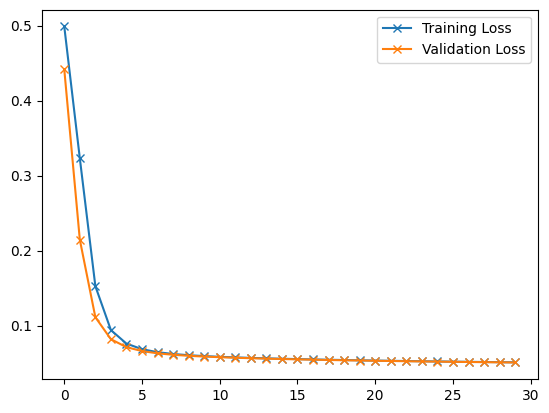

In [ ]:
plt.figure()
plt.plot(trainer.train_loss, label='Training Loss', marker='x')
plt.plot(trainer.validation_loss, label='Validation Loss', marker='x')
# plt.yscale('log')
plt.legend()

loss_curves = plt.gcf()

In [ ]:
print(trainer)


        Model Properties:
        PerceptronBD(
  (model): Sequential(
    (0): Linear(in_features=20, out_features=20, bias=True)
    (1): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=20, out_features=25, bias=True)
    (4): BatchNorm1d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=25, out_features=30, bias=True)
    (7): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Linear(in_features=30, out_features=22, bias=True)
    (10): Flatten(start_dim=1, end_dim=-1)
  )
)
        Optimizer Properties"
        SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.0001
    maximize: False
    momentum: 0.91
    nesterov: False
    weight_decay: 0.0001
)
        DataLoader Params: 
            Batch Size: 512
            Validation Method: Split the dat

In [ ]:
# Increase batch_size for faster visuals generation - (does not affect training!)
# trainer.change_batch_size(4096)

# train_error, train_pred = generate_model_error_and_prediction(trainer.model, trainer.train_loader, y_columns, y_scaler, error_func=criterion)
# val_error, val_pred = generate_model_error_and_prediction(trainer.model, trainer.validation_loader, y_columns, y_scaler)

In [ ]:
# fig_dist, axes = plt.subplots(3, len(y_columns), squeeze=True, figsize=(17, 8), sharey=True)
# BIN_COUNT = 50

# train_data = y_scaler.inverse_transform(trainer.train_loader.dataset[:][1])
# val_data = y_scaler.inverse_transform(trainer.validation_loader.dataset[:][1])

# for i in range(len(y_columns)):
#     # Plot Errors
#     ax = axes[0, i]
#     plt.sca(ax)
#     column_name = train_error.columns[i]
#     plt.hist(train_error[column_name], bins=BIN_COUNT, color='blue', alpha=0.5, label='Train')
#     plt.hist(val_error[column_name], bins=BIN_COUNT, color='orange', alpha=0.5, label='Validation')

    
#     # Plot Predictions
#     ax = axes[1, i]
#     plt.sca(ax)
#     column_name = train_pred.columns[i]
#     plt.hist(train_pred[column_name], bins=BIN_COUNT, color='blue', alpha=0.5, label='Train')
#     plt.hist(val_pred[column_name], bins=BIN_COUNT, color='orange', alpha=0.5, label='Validation')

    
#     # Plot Ground Truth
#     ax = axes[2, i]
#     plt.sca(ax)
#     plt.hist(train_data[:, i], bins=BIN_COUNT, color='blue', alpha=0.5, label='Train')
#     plt.hist(val_data[:, i], bins=BIN_COUNT, color='orange', alpha=0.5, label='Validation')

#     # X Label for the bottommost row
#     plt.xlabel(y_columns[i])
    
# # Add text to the left of each row of plots
# for i, label in enumerate(['MAE Error', 'Prediction', 'Ground Truth']):
#     fig_dist.text(0, (2.5-i)/3, label, ha='center', va='center', rotation='vertical')

# # Y Labels
# for i in range(axes.shape[0]):
#     axes[i, 0].set_ylabel('Count')

# # Add labels to top-left subplot
# axes[0, 0].legend()


# plt.tight_layout()
# plt.show()

In [ ]:
# # Top Bad Samples
# VIEW_TOP_N = 50
# worst_errors = error_df['Absolute Error'].argsort()[::-1][:VIEW_TOP_N]  # Worst Results
# # worst_errors = error_df['Absolute Error'].argsort()[:VIEW_TOP_N]  # Best Results
# combined_table = data.join(error_df)
# with pd.option_context("display.max_rows", None):
#     display(combined_table[['Maternal Wall Thickness', "Maternal Hb Concentration", "Maternal Saturation", "Fetal Hb Concentration", "Fetal Saturation", 'Truth', 'Predicted', 'Absolute Error', '%tage']].iloc[worst_errors, :])

In [ ]:
# # Rough MSE's in percentage
# print(f'Train Error(non-normalized): {trainer.train_loss[-1] * y_scaler.var_ }')
# print(f'Validation Error(non-normalized): {trainer.validation_loss[-1] * y_scaler.var_ }')

In [ ]:
# Model Info
torchinfo.summary(trainer.model)

Layer (type:depth-idx)                   Param #
PerceptronBD                             --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       420
│    └─BatchNorm1d: 2-2                  40
│    └─ReLU: 2-3                         --
│    └─Linear: 2-4                       525
│    └─BatchNorm1d: 2-5                  50
│    └─ReLU: 2-6                         --
│    └─Linear: 2-7                       780
│    └─BatchNorm1d: 2-8                  60
│    └─ReLU: 2-9                         --
│    └─Linear: 2-10                      682
│    └─Flatten: 2-11                     --
Total params: 2,557
Trainable params: 2,557
Non-trainable params: 0

In [ ]:
# model_name = 'msat_percep_irsi'
# import joblib
# # Save Model
# torch.save(model.state_dict(), rf'../models/{model_name}')
# # Save the Scalers for Later Use
# joblib.dump(x_scaler, rf'../models/{model_name}_xscaler')
# joblib.dump(y_scaler, rf'../models/{model_name}_yscaler')

In [ ]:
# # Load Model Code
# model = PerceptronReLU([20, 10, 4, 2, 1])
# model.load_state_dict(torch.load(r'../models/fsat_delta_5det_v1'))
# model = model.cuda()
# x_scaler = joblib.load(rf'../models/{model_name}_xscaler')
# y_scaler = joblib.load(rf'../models/{model_name}_yscaler')

In [ ]:
# from inverse_modelling_tfo.misc import MarkdownReport
# # Generate report

# report = MarkdownReport(Path('results'), 'report7', 'Inverse Modelling Report')
# report.add_text_report("Objective", "Predicting with 90% Random Split(As opposed to a hold One out style). Same as report6. Except, trying out a different normalization scheme. Where it scales all detector intensity logs using a single scale. More specifically, maps the values from -1 to -20 between -1 and +1. The intuition behind this was that this sort of normalization should preserve inter-detector scaling.")
# report.add_text_report("Comments", "Somehow performs slightly worse than per detector scaling. Which does not make sense to me")
# report.add_text_report("Data Length", str(len(data)))
# report.add_code_report("Model Used", str(torchinfo.summary(trainer.model)))
# report.add_code_report("Model Trainer Params", str(trainer))
# report.add_image_report("Loss Curves", loss_curves)
# report.add_image_report("Prediction & Error Distribution", fig_dist)
# report.save_report()